** File Description **
This file is for problem3.
Ensemble was implemented using Mask2Former model and Unet model. 
Each model was trained in Mask2Former.ipynb file and Unet.ipynb file.

In [1]:
%pip install -q git+https://github.com/huggingface/transformers.git
# %pip install -q matplotlib rasterio numpy requests torch scipy albumentations

import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import random
from PIL import Image
import rasterio
import warnings
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

import torch
from torch import nn
import torch.optim as optim
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation, Mask2FormerConfig
from torch.utils.data import Dataset,DataLoader
from tqdm.auto import tqdm
from torch.optim import AdamW
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
import cv2
import segmentation_models_pytorch as smp


Note: you may need to restart the kernel to use updated packages.


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.8.0+cu128  Device: cuda


In [3]:
# r_min = 1121.969
# r_max = 4942.150
# g_min = 1207.664
# g_max = 4702.109
# b_min = 1053.633
# b_max = 4507.207

r_min = 1045.748
r_max = 6740.959
g_min = 1102.797
g_max = 6511.914
b_min = 959.977
b_max = 6216.434

mean_r = 0.186763
mean_g = 0.174535
mean_b = 0.164897
std_r  = 0.120966
std_g  = 0.103745
std_b  = 0.107954

In [4]:
processor = AutoImageProcessor.from_pretrained(
    "facebook/mask2former-swin-large-cityscapes-semantic", 
    do_rescale = False,
    do_normalize = True,
    image_mean = [mean_r, mean_g, mean_b],
    image_std = [std_r, std_g, std_b]
)
id2label = {0: "background", 1: "target"}
label2id = {v: k for k, v in id2label.items()}
config = Mask2FormerConfig.from_pretrained(
    "facebook/mask2former-swin-large-cityscapes-semantic",
    id2label=id2label, label2id=label2id, num_labels=len(id2label)
)
config.backbone_config.drop_rate = 0.1
config.backbone_config.attn_drop_rate = 0.1
config.backbone_config.drop_path_rate = 0.1
m2f_model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-large-cityscapes-semantic",
    config=config,
    ignore_mismatched_sizes=True
).to(DEVICE)

unet_model = smp.Unet(
  encoder_name="mit_b5",
  encoder_weights="imagenet",
  in_channels=3,
  classes=2
).to(DEVICE)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/venv/main/lib/python3.12/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_predictor.weight: found shape torch.Size([20, 256]) in the ch

In [5]:
def to_float32(img, **kwargs):
    return img.astype(np.float32, copy=False)

def keep_mask_int(msk, **kwargs):
    if msk.dtype != np.int64:
        msk = msk.astype(np.int64, copy=False)
    return msk

def clip01(img, **kwargs):
    return np.clip(img, 0.0, 1.0)

H, W = 512, 512

transform = A.Compose([
    A.Lambda(image=to_float32, mask=keep_mask_int),

    # A.OneOf([
    #     A.RandomResizedCrop(size=(H, W), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    #     A.Resize(H, W)
    # ], p=1.0),

    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=1.0),

    A.OneOf([
        A.GaussNoise(std_range=(0.0, 0.005), mean=0.0, p=1.0),
        A.MultiplicativeNoise(multiplier=(0.95, 1.05), per_channel=True, p=1.0),
    ], p=0.3),
    # A.OneOf([
    #     A.GaussianBlur(blur_limit=(2, 3), p=1.0),
    #     A.MotionBlur(blur_limit=3, p=1.0),
    # ], p=0.3),

    # A.OneOf([
    #     A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1.0),
    #     A.RandomGamma(gamma_limit=(80, 120), p=1.0),
    #     A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    # ], p=0.5),

    A.Lambda(image=clip01),
])


def augmentation(image, mask):
    # image: (H,W,3), float32, range (0,1)
    # mask : (H,W), int, 0/1
    out = transform(image=image, mask=mask)
    img_aug, msk_aug = out["image"], out["mask"]
    return img_aug, msk_aug

/tmp/ipykernel_46604/3328358828.py:27: UserWarning: Argument(s) 'mean' are not valid for transform GaussNoise
  A.GaussNoise(std_range=(0.0, 0.005), mean=0.0, p=1.0),


In [6]:
##label은 10/90으로 구성된다... 10이 검은색 /  90이 노란색

class SatelliteImageDataset(Dataset):
  def __init__(self, img_dir, label_dir, transform=None):
    self.img_dir   = img_dir
    self.label_dir = label_dir
    self.transform = transform

    self.img_files   = sorted([f for f in os.listdir(img_dir) if f.endswith('.tif')])
    self.label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.tif')])
    assert len(self.img_files) == len(self.label_files), "data number mismatch"

  def __len__(self):
    return len(self.img_files)

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_files[idx])
    label_path = os.path.join(self.label_dir, self.label_files[idx])

    with rasterio.open(img_path) as src:
      red   = src.read(1).astype(np.float32)
      green = src.read(2).astype(np.float32)
      blue  = src.read(3).astype(np.float32)

      red   = (red   - r_min) / (r_max - r_min)
      green = (green - g_min) / (g_max - g_min)
      blue  = (blue  - b_min) / (b_max - b_min)

      image = np.dstack((red, green, blue))
      image = image.clip(0, 1)

    with rasterio.open(label_path) as src:
      label = src.read(1)
      label = (label==10).astype(np.int64)

    if self.transform:
      image, label = self.transform(image, label)

    image = torch.from_numpy(image).float().permute(2,0,1)  #(H,W,C) => (C,H,W)
    label = torch.from_numpy(label).long()
    return image, label


In [7]:
def collate_fn(batch):
    imgs  = [img.permute(1,2,0).numpy() for (img, msk) in batch] # CHW -> HWC float32[0,1]
    masks = [msk.numpy().astype(np.int64) for (img, msk) in batch] # HW int64

    enc = processor(
        images=imgs,
        segmentation_maps=masks,
        return_tensors="pt",
        size={"height": 512, "width": 512},
        do_rescale=False,
    )

    unet_imgs  = torch.stack([img for img, msk in batch], dim=0) # (B,3,512,512)
    unet_masks = torch.stack([msk for img, msk in batch], dim=0)
    enc["imgs"] = unet_imgs
    enc["unet_targets"] = unet_masks
    return enc

In [8]:
#hyperparameter set
batch_size = 4
lr = 0.0001
num_epochs = 30

In [16]:
train_data = SatelliteImageDataset(img_dir='/root/workspace/train/TS_SN10_SN10',label_dir='/root/workspace/train/TL_SN10',transform=augmentation)
val_data = SatelliteImageDataset(img_dir='/root/workspace/val/VS_SN10_SN10',label_dir='/root/workspace/val/VL_SN10',transform=None)
m2f_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, collate_fn=collate_fn)
m2f_val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn)
unet_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
unet_val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [11]:
NUM_CLASSES = m2f_model.config.num_labels
ENSEMBLE_WEIGHTS = (0.5, 0.5) # (m2f_prob, unet_prob)
EPS = 1e-6
MIOU_INTERVAL = 10
unet_ckpt= '/root/workspace/models/mit_b5_model_noise.pth'
m2f_ckpt = '/root/workspace/models/Mask2Former_model.pth'

In [12]:
def accumulate_miou(inter, union):
    iou = inter / (union + 1e-10)
    valid = union > 0
    return (iou[valid].mean().item() if valid.any() else float("nan"))

@torch.no_grad()
def accumulate_inter_union(pred, tgt, num_classes):
    inter = torch.zeros(num_classes, dtype=torch.float64, device=pred.device)
    union = torch.zeros(num_classes, dtype=torch.float64, device=pred.device)
    for c in range(num_classes):
        p = (pred == c)
        t = (tgt == c)
        inter[c] += (p & t).sum().double()
        union[c] += (p | t).sum().double()
    return inter, union

def build_targets(mask_labels_list, class_labels_list, H, W, device):
    tgts = []
    for masks, classes in zip(mask_labels_list, class_labels_list):
        tgt = torch.zeros((H, W), dtype=torch.long, device=device)
        if masks.ndim == 3:
            for m, c in zip(masks, classes):
                tgt[m.bool()] = int(c.item())
        tgts.append(tgt)
    return tgts

# =========================
# m2f: 확률 맵 생성 + TTA
# =========================
@torch.no_grad()
def m2f_sem_probs_from_outputs(m2f_outputs, H, W, num_classes=2):
    class_scores = m2f_outputs.class_queries_logits.softmax(-1)[..., :num_classes]  # (B,Q,C)
    mask_probs   = m2f_outputs.masks_queries_logits.sigmoid()                       # (B,Q,h',w')
    sem_lowres   = torch.einsum('bqc,bqhw->bchw', class_scores, mask_probs)         # (B,C,h',w')
    sem          = F.interpolate(sem_lowres, size=(H, W), mode='bilinear', align_corners=False)
    return sem.clamp(0.0, 1.0)  # (B,C,H,W)

@torch.no_grad()
def m2f_tta_probs(model, pixel_values, num_classes):
    B, C, H, W = pixel_values.shape
    probs_acc, nviews = None, 0

    def fwd(x, undo):
        nonlocal probs_acc, nviews
        x = x.contiguous()
        output = model(pixel_values=x)
        prob = m2f_sem_probs_from_outputs(output, H, W, num_classes)  # (B,C,out_H,out_W)
        prob = undo(prob)
        probs_acc = prob if probs_acc is None else probs_acc + prob
        nviews += 1

    x = pixel_values
    out_H, out_W = H, W
    fwd(x, undo=lambda t: t) # identity
    fwd(x.flip(-1), undo=lambda t: t.flip(-1)) # hflip
    fwd(x.flip(-2), undo=lambda t: t.flip(-2)) # vflip
    fwd(x.transpose(-1, -2), undo=lambda t: t.transpose(-1, -2)) # transpose

    probs_mean = probs_acc / float(nviews)          # (B,C,H,W)
    return probs_mean

import torch
import torch.nn.functional as F

@torch.no_grad()
def m2f_probs_like_processor(outputs, target_H, target_W, num_classes, pixel_mask=None):
    class_logits = outputs.class_queries_logits              # (B,Q,C+1)
    mask_logits  = outputs.masks_queries_logits              # (B,Q,h',w')
    class_scores = class_logits.softmax(-1)[..., :num_classes]  # drop no-object → (B,Q,C)

    mask_logits_up = F.interpolate(mask_logits, size=(target_H, target_W),
                                   mode='bilinear', align_corners=False)        # (B,Q,H,W)

    mask_probs = mask_logits_up.sigmoid()                                        # (B,Q,H,W)

    if pixel_mask is not None:
        pm_up = F.interpolate(pixel_mask[:, None].float(), size=(target_H, target_W),
                              mode='nearest').squeeze(1)                         # (B,H,W)
        mask_probs = mask_probs * pm_up[:, None]                                 # (B,Q,H,W)

    # sem[b,c,h,w] = sum_q class_scores[b,q,c] * mask_probs[b,q,h,w]
    sem = torch.einsum('bqc,bqhw->bchw', class_scores, mask_probs)               # (B,C,H,W)
    sem = torch.softmax(sem, dim=1)

    return sem.clamp_(0, 1)


# =========================
# unet: 확률 맵 생성 + TTA
# =========================
@torch.no_grad()
def unet_sem_probs_from_logits(unet_logits):
    probs = torch.softmax(unet_logits, dim=1)  # (B,C,H,W)
    return probs

@torch.no_grad()
def unet_tta_probs(unet_model, imgs):
    B, C, H, W = imgs.shape
    probs_acc, nviews = None, 0

    def fwd(x, undo):
        nonlocal probs_acc, nviews
        x = x.contiguous()
        output = unet_model(x)
        probs  = unet_sem_probs_from_logits(output)
        probs  = undo(probs)
        probs_acc = probs if probs_acc is None else (probs_acc + probs)
        nviews += 1

    x = imgs
    fwd(x, undo=lambda t: t) # identity
    fwd(x.flip(-1), undo=lambda t: t.flip(-1)) # hflip
    fwd(x.flip(-2), undo=lambda t: t.flip(-2)) # vflip
    fwd(x.transpose(-1, -2), undo=lambda t: t.transpose(-1, -2)) # transpose

    probs_mean = probs_acc / float(nviews) 
    return probs_mean

In [ ]:
# UNet
unet_model = smp.Unet(
    encoder_name    = "mit_b5",
    encoder_weights = "imagenet",
    in_channels     = 3,
    classes         = NUM_CLASSES
).to(DEVICE)

unet_criterion = nn.CrossEntropyLoss()
unet_optimizer = optim.Adam(unet_model.parameters(), lr=lr)
unet_scheduler = CosineAnnealingLR(unet_optimizer, T_max=30, eta_min=1e-5)
unet_start_epoch = 0
if os.path.exists(unet_ckpt):
    unet_ckpt_data = torch.load(unet_ckpt, weights_only=False)
    unet_model.load_state_dict(unet_ckpt_data['model'])
    unet_optimizer.load_state_dict(unet_ckpt_data['optimizer'])
    unet_scheduler.load_state_dict(unet_ckpt_data['scheduler'])
    unet_start_epoch  = unet_ckpt_data['epoch'] + 1
    unet_train_losses = unet_ckpt_data.get('train_losses', [])
    unet_val_losses   = unet_ckpt_data.get('val_losses', [])
    unet_train_mious  = unet_ckpt_data.get('train_mious', [])
    unet_val_mious    = unet_ckpt_data.get('val_mious', [])
    print(f"[UNet] Resume from epoch {unet_start_epoch}")
else:
    unet_train_losses, unet_val_losses = [], []
    unet_train_mious, unet_val_mious   = [], []
for epoch in range(unet_start_epoch, num_epochs):
    # train
    unet_model.train()
    train_loss  = []
    train_inter = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=DEVICE)
    train_union = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=DEVICE)
    for imgs, labels in unet_train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        output = unet_model(imgs)
        loss = unet_criterion(output, labels)
        unet_optimizer.zero_grad()
        loss.backward()
        unet_optimizer.step()
        train_loss.append(loss.item())
        preds = output.argmax(1)
        # train iou accumulate
        inter, uni = accumulate_inter_union(preds, labels, NUM_CLASSES)
        train_inter += inter
        train_union += uni
    unet_scheduler.step()
    train_miou = accumulate_miou(train_inter, train_union)
    train_avg_loss = float(np.mean(train_loss))
    unet_train_mious.append(train_miou)
    unet_train_losses.append(train_avg_loss)
    # validation
    unet_model.eval()
    val_loss  = []
    val_inter = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=DEVICE)
    val_union = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=DEVICE)
    with torch.no_grad():
        for imgs, labels in unet_val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            output = unet_model(imgs)
            loss = unet_criterion(output, labels)
            val_loss.append(loss.item())
            preds = output.argmax(1)
            # val iou accumulate
            inter, uni = accumulate_inter_union(preds, labels, NUM_CLASSES)
            val_inter += inter
            val_union += uni
    val_miou = accumulate_miou(val_inter, val_union)
    val_avg_loss = float(np.mean(val_loss))
    unet_val_mious.append(val_miou)
    unet_val_losses.append(val_avg_loss)
    print(f"[UNet] Epoch {epoch+1}/{num_epochs} | "
          f"train_loss={unet_train_losses[-1]:.4f} | val_loss={unet_val_losses[-1]:.4f} | "
          f"train_mIoU={unet_train_mious[-1]:.4f} | val_mIoU={unet_val_mious[-1]:.4f}")

    torch.save({
        'model': unet_model.state_dict(),
        'optimizer': unet_optimizer.state_dict(),
        'scheduler': unet_scheduler.state_dict(),
        'epoch': epoch,
        'train_losses': unet_train_losses,
        'val_losses': unet_val_losses,
        'train_mious': unet_train_mious,
        'val_mious': unet_val_mious
    }, unet_ckpt)


In [ ]:
# Mask2Former
m2f_optimizer = optim.AdamW(m2f_model.parameters(), lr=lr, weight_decay=1e-2)
m2f_scheduler = CosineAnnealingLR(m2f_optimizer, T_max=30, eta_min=lr/10)

m2f_start_epoch = 0
if os.path.exists(m2f_ckpt):
    m2f_ckpt_data = torch.load(m2f_ckpt, weights_only=False)
    m2f_model.load_state_dict(m2f_ckpt_data['model'])
    m2f_optimizer.load_state_dict(m2f_ckpt_data['optimizer'])
    m2f_scheduler.load_state_dict(m2f_ckpt_data['scheduler'])
    m2f_start_epoch  = m2f_ckpt_data['epoch'] + 1
    m2f_train_losses = m2f_ckpt_data.get('losses', [])
    m2f_val_losses   = m2f_ckpt_data.get('val_losses', [])
    m2f_train_mIoUs  = m2f_ckpt_data.get('train_mIoUs', [])
    m2f_val_mIoUs    = m2f_ckpt_data.get('val_mIoUs', [])
    print(f"[M2F] Resume from epoch {m2f_start_epoch}")
else:
    m2f_train_losses, m2f_val_losses = [], []
    m2f_train_mIoUs, m2f_val_mIoUs   = [], []

for epoch in range(m2f_start_epoch, num_epochs):
    # train
    m2f_model.train()
    train_running = 0.0
    train_inter = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=DEVICE)
    train_union = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=DEVICE)
    m2f_train_bar = tqdm(m2f_train_loader, desc=f"[M2F] Train {epoch+1}/{num_epochs}", leave=False)
    for step, batch in enumerate(m2f_train_bar, 1):
        m2f_pv = batch["pixel_values"].to(DEVICE)
        m2f_ml = [x.to(DEVICE) for x in batch["mask_labels"]]
        m2f_cl = [x.to(DEVICE) for x in batch["class_labels"]]

        output = m2f_model(pixel_values=m2f_pv, mask_labels=m2f_ml, class_labels=m2f_cl)
        loss = output.loss

        m2f_optimizer.zero_grad()
        loss.backward()
        m2f_optimizer.step()
        train_running += loss.item()
        # train iou accumulate
        if step % MIOU_INTERVAL == 0:
            H, W = m2f_pv.shape[-2], m2f_pv.shape[-1]
            with torch.no_grad():
                probs = m2f_sem_probs_from_outputs(output, H, W, NUM_CLASSES) # (B,2,H,W)
                pred = probs.argmax(1) # (B,H,W)
                tgts = build_targets(m2f_ml, m2f_cl, H, W, device=m2f_pv.device) # (B,H,W)
                tgts = build_targets(m2f_ml, m2f_cl, H, W, device=m2f_pv.device)
                for p, t in zip(pred, tgts):
                    inter, uni = accumulate_inter_union(p, t, NUM_CLASSES)
                    train_inter += inter
                    train_union += uni
            mIoU_now = accumulate_miou(train_inter, train_union)
            m2f_train_bar.set_postfix(loss=f"{train_running/step:.4f}", mIoU=f"{mIoU_now:.4f}")
        else:
            m2f_train_bar.set_postfix(loss=f"{train_running/step:.4f}")
    train_mIoU = accumulate_miou(train_inter, train_union)
    m2f_train_mIoUs.append(train_mIoU)
    m2f_train_losses.append(train_running / max(1, len(m2f_train_loader)))
    m2f_scheduler.step()

    # validation
    m2f_model.eval()
    val_running = 0.0
    inter = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=DEVICE)
    uni   = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=DEVICE)
    with torch.no_grad():
        for batch in m2f_val_loader:
            m2f_pv = batch["pixel_values"].to(DEVICE)
            m2f_ml = [x.to(DEVICE) for x in batch["mask_labels"]]
            m2f_cl = [x.to(DEVICE) for x in batch["class_labels"]]

            out = m2f_model(pixel_values=m2f_pv, mask_labels=m2f_ml, class_labels=m2f_cl)
            val_running += out.loss.item()

            H, W  = m2f_pv.shape[-2], m2f_pv.shape[-1]
            probs = m2f_sem_probs_from_outputs(out, H, W, NUM_CLASSES) # (B,2,H,W)
            pred  = probs.argmax(1) # (B,H,W)
            tgts  = build_targets(m2f_ml, m2f_cl, H, W, device=m2f_pv.device)
            for p, t in zip(pred, tgts):
                i, u = accumulate_inter_union(p, t, NUM_CLASSES)
                inter += i
                uni += u
    m2f_train_mIoUs.append(float("nan"))
    m2f_val_losses.append(val_running / max(1, len(m2f_val_loader)))
    m2f_val_mIoUs.append(accumulate_miou(inter, uni))

    print(f"[M2F] Epoch {epoch+1}/{num_epochs} | "
          f"train_loss={m2f_train_losses[-1]:.4f} | val_loss={m2f_val_losses[-1]:.4f} | "
          f"train_mIoU={m2f_train_mIoUs[-1]:.4f} | val_mIoU={m2f_val_mIoUs[-1]:.4f}")

    torch.save({
        'model': m2f_model.state_dict(),
        'optimizer': m2f_optimizer.state_dict(),
        'scheduler': m2f_scheduler.state_dict(),
        'epoch': epoch,
        'train_losses': m2f_train_losses,
        'val_losses': m2f_val_losses,
        'train_mIoU': m2f_train_mIoUs,
        'val_mIoU': m2f_val_mIoUs
    }, m2f_ckpt)

In [17]:
NUM_CLASSES = m2f_model.config.num_labels
ENSEMBLE_WEIGHTS = (0.5, 0.5) # (m2f_prob, unet_prob)

unet_ckpt_data = torch.load(unet_ckpt, map_location=DEVICE, weights_only=False)
unet_state_dict = unet_ckpt_data['model']
m2f_ckpt_data = torch.load(m2f_ckpt, map_location=DEVICE)
m2f_state_dict = m2f_ckpt_data['model']

unet_model.load_state_dict(unet_state_dict)
m2f_model.load_state_dict(m2f_state_dict)

<All keys matched successfully>

In [18]:
@torch.no_grad()
def ensemble_validate_epoch(unet_model, m2f_model, m2f_val_loader, weights, device=DEVICE):
    unet_model.eval()
    m2f_model.eval()

    w_m2f, w_unet = weights
    wsum = (w_m2f + w_unet) if (w_m2f + w_unet) != 0 else 1.0

    inter = torch.zeros(2, dtype=torch.float64, device=device)
    union = torch.zeros(2, dtype=torch.float64, device=device)

    bar = tqdm(m2f_val_loader, desc="[ENSEMBLE] Val (TTA)", leave=False)
    for batch in bar:
        m2f_pv = batch["pixel_values"].to(device)   # (B,3,H,W)
        unet_imgs = batch["imgs"].to(device)

        m2f_ml = [x.to(device, non_blocking=True) for x in batch["mask_labels"]]
        m2f_cl = [x.to(device, non_blocking=True) for x in batch["class_labels"]]
        B, C, H, W = m2f_pv.shape
        m2f_outputs = m2f_model(m2f_pv)
        m2f_probs = m2f_probs_like_processor(m2f_outputs, H, W, NUM_CLASSES)
        p_fg_m2f  = m2f_probs[:, 1]

        unet_outputs = unet_model(unet_imgs)
        unet_probs = unet_sem_probs_from_logits(unet_outputs)
        p_fg_unet  = unet_probs[:, 1]

        p_fg_ens = (w_m2f * p_fg_m2f + w_unet * p_fg_unet) / wsum                 # (B,H,W)

        pred = (p_fg_ens >= 0.5).long()                                           # (B,H,W)

        gt = batch["unet_targets"].to(device)
        # gt = build_targets(m2f_ml, m2f_cl, H, W, device=device)
        for p_mask, t_mask in zip(pred, gt):
            i, u = accumulate_inter_union(p_mask, t_mask, 2)
            inter += i
            union += u

        bar.set_postfix(mIoU=f"{accumulate_miou(inter, union):.4f}")

    return accumulate_miou(inter, union)

In [36]:
# ensemble_miou = ensemble_validate_epoch(
#     unet_model, m2f_model, m2f_val_loader,
#     weights = (0.5, 0.5), # (m2f_prob, unet_prob)
#     device = DEVICE
# )
# print(f"Ensemble mIoU: {ensemble_miou:.4f}")
alphas = np.linspace(0.0, 1.0, 11)  # 0.00, 0.1, ..., 1.00
results = []
best_w, best_miou = None, -1.0

for a in alphas:
    w = (float(1.0-a), float(a))  # (m2f_prob, unet_prob)
    miou = ensemble_validate_epoch(
        unet_model, m2f_model, m2f_val_loader,
        weights=w, device=DEVICE
    )
    results.append((w[0], w[1], miou))
    print(f"alpha={a:>4.2f} | m2f={w[0]:.2f}, unet={w[1]:.2f} -> mIoU={miou:.4f}")
    if miou > best_miou:
        best_w, best_miou = w, miou

print("\nBest weights:")
print(f"m2f={best_w[0]:.2f}, unet={best_w[1]:.2f} -> mIoU={best_miou:.4f}")

[ENSEMBLE] Val (TTA):   0%|          | 0/250 [00:00<?, ?it/s]

alpha=0.00 | m2f=1.00, unet=0.00 -> mIoU=0.9796


[ENSEMBLE] Val (TTA):   0%|          | 0/250 [00:00<?, ?it/s]

alpha=0.10 | m2f=0.90, unet=0.10 -> mIoU=0.9803


[ENSEMBLE] Val (TTA):   0%|          | 0/250 [00:00<?, ?it/s]

alpha=0.20 | m2f=0.80, unet=0.20 -> mIoU=0.9809


[ENSEMBLE] Val (TTA):   0%|          | 0/250 [00:00<?, ?it/s]

alpha=0.30 | m2f=0.70, unet=0.30 -> mIoU=0.9812


[ENSEMBLE] Val (TTA):   0%|          | 0/250 [00:00<?, ?it/s]

alpha=0.40 | m2f=0.60, unet=0.40 -> mIoU=0.9795


[ENSEMBLE] Val (TTA):   0%|          | 0/250 [00:00<?, ?it/s]

alpha=0.50 | m2f=0.50, unet=0.50 -> mIoU=0.9782


[ENSEMBLE] Val (TTA):   0%|          | 0/250 [00:00<?, ?it/s]

alpha=0.60 | m2f=0.40, unet=0.60 -> mIoU=0.9771


[ENSEMBLE] Val (TTA):   0%|          | 0/250 [00:00<?, ?it/s]

alpha=0.70 | m2f=0.30, unet=0.70 -> mIoU=0.9762


[ENSEMBLE] Val (TTA):   0%|          | 0/250 [00:00<?, ?it/s]

alpha=0.80 | m2f=0.20, unet=0.80 -> mIoU=0.9755


[ENSEMBLE] Val (TTA):   0%|          | 0/250 [00:00<?, ?it/s]

alpha=0.90 | m2f=0.10, unet=0.90 -> mIoU=0.9748


[ENSEMBLE] Val (TTA):   0%|          | 0/250 [00:00<?, ?it/s]

alpha=1.00 | m2f=0.00, unet=1.00 -> mIoU=0.9743

Best weights:
m2f=0.70, unet=0.30 -> mIoU=0.9812


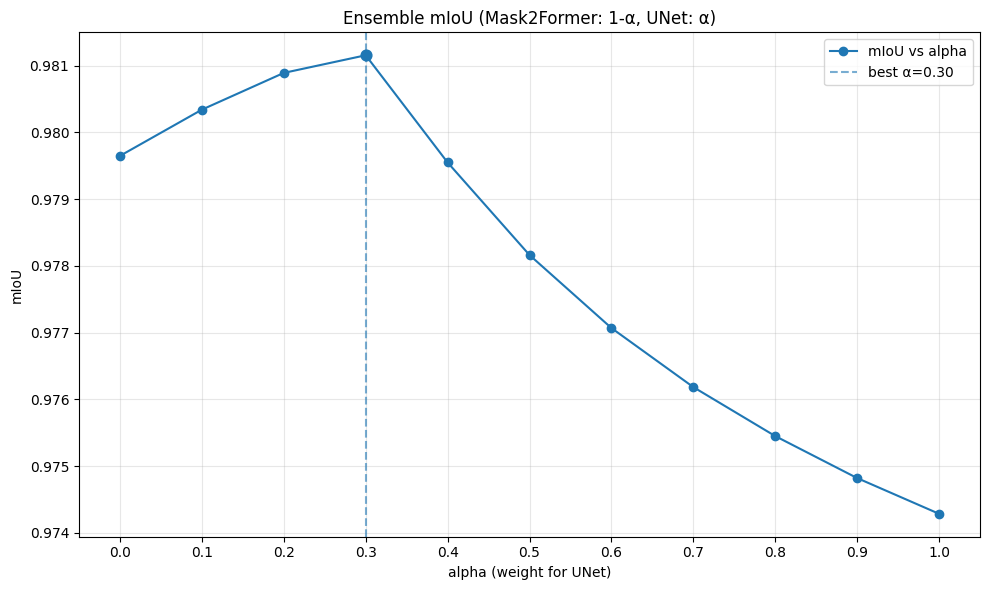

In [43]:
alphas_plot = np.array([unet_w for (_, unet_w, _) in results], dtype=float)
mious_plot  = np.array([miou    for (_, _, miou) in results], dtype=float)
best_idx   = int(np.nanargmax(mious_plot))
best_alpha = float(alphas_plot[best_idx])
best_miou  = float(mious_plot[best_idx])
plt.figure(figsize=(10, 6))

plt.plot(alphas_plot, mious_plot, marker='o', linewidth=1.5, label='mIoU vs alpha')
plt.axvline(best_alpha, linestyle='--', alpha=0.6, label=f'best α={best_alpha:.2f}')
plt.scatter([best_alpha], [best_miou], s=60, zorder=3)

plt.xticks(alphas_plot)              # 0.00, 0.10, ..., 1.00
plt.xlabel('alpha (weight for UNet)')
plt.ylabel('mIoU')
plt.title('Ensemble mIoU (Mask2Former: 1-α, UNet: α)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(512, 512, 3) (512, 512)


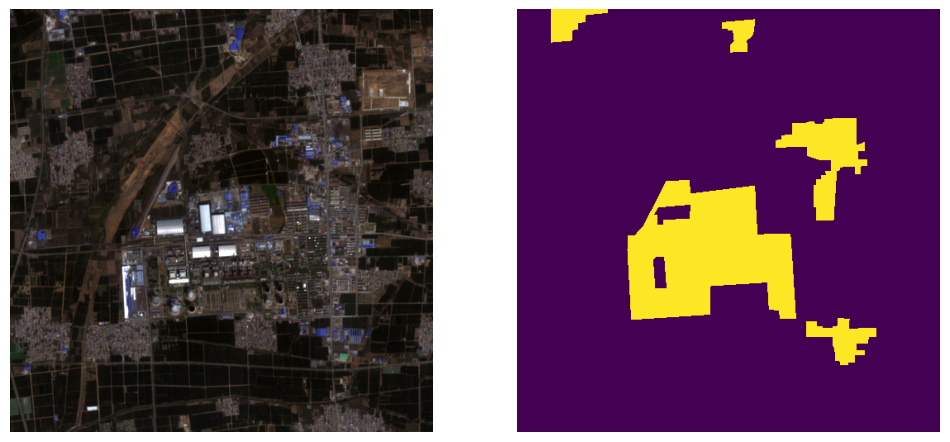

In [33]:
file_name = '/root/workspace/train/TS_SN10_SN10/SN10_CHN_00013_230409.tif'
label_name = '/root/workspace/train/TL_SN10/SN10_CHN_00013_230409.tif'
with rasterio.open(file_name) as src:
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)
    red   = (red   - r_min) / (r_max   - r_min)
    green = (green - g_min) / (g_max - g_min)
    blue  = (blue  - b_min) / (b_max  - b_min)
    img = np.dstack((red, green, blue))
    img = img.clip(0, 1)
with rasterio.open(label_name) as src:
    label = src.read(1)
    label = (label==10).astype(np.int64)
# img, label = augmentation(img, label)
inputs = processor(images=img, return_tensors="pt", do_rescale=False)
fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(img)
ax[1].imshow(label)
print(type(img), type(label))
print(img.shape, label.shape)

In [34]:
from matplotlib.colors import ListedColormap, BoundaryNorm

@torch.no_grad()
def visualize_ensemble_pred_4panel(img, mask):
    """
    img  : numpy (H,W,3) float32 in [0,1]
    mask : numpy (H,W) uint8/int, values {0,1} or {10,90}
    """
    H, W = img.shape[:2]

    m2f_model.eval()
    unet_model.eval()

    # Mask2Former 입력
    with torch.no_grad():
        enc = processor(images=[img], return_tensors="pt", do_rescale=False, size={"height": 512, "width": 512})
    pixel_values = enc["pixel_values"].to(DEVICE) # (1,3,H,W)

    # UNet 입력
    unet_imgs = torch.from_numpy(img).float().permute(2,0,1)
    unet_imgs = unet_imgs.unsqueeze(0).to(DEVICE)

    # 각 모델 전경 확률
    m2f_output = m2f_model(pixel_values=pixel_values)
    m2f_probs = m2f_probs_like_processor(m2f_output, H, W, NUM_CLASSES)
    p_fg_m2f  = m2f_probs[:, 1]  # (1,hm,wm)

    unet_output = unet_model(unet_imgs)
    unet_probs = unet_sem_probs_from_logits(unet_output)
    p_fg_unet  = unet_probs[:, 1]  # (1,H,W)

    w_m2f, w_unet = ENSEMBLE_WEIGHTS
    wsum = (w_m2f + w_unet) if (w_m2f + w_unet) != 0 else 1.0
    p_fg_ens = (w_m2f * p_fg_m2f + w_unet * p_fg_unet) / wsum   # (1,H,W)

    pred_unet = (p_fg_unet >= 0.5).squeeze(0).detach().cpu().numpy().astype(np.uint8)
    pred_m2f  = (p_fg_m2f  >= 0.5).squeeze(0).detach().cpu().numpy().astype(np.uint8)
    pred_ens  = (p_fg_ens  >= 0.5).squeeze(0).detach().cpu().numpy().astype(np.uint8)

    # --- 시각화 (0=검정, 1=노랑)
    cmap = ListedColormap([[0,0,0], [1,1,0]])
    norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

    fig, ax = plt.subplots(1, 4, figsize=(16, 6))
    ax[0].imshow(pred_unet, cmap=cmap, norm=norm); ax[0].set_title("UNet");         ax[0].axis('off')
    ax[1].imshow(pred_m2f,  cmap=cmap, norm=norm); ax[1].set_title("Mask2Former");  ax[1].axis('off')
    ax[2].imshow(pred_ens,  cmap=cmap, norm=norm); ax[2].set_title("Ensemble");     ax[2].axis('off')
    ax[3].imshow(mask,      cmap=cmap, norm=norm); ax[3].set_title("Ground Truth"); ax[3].axis('off')
    plt.tight_layout(); plt.show()


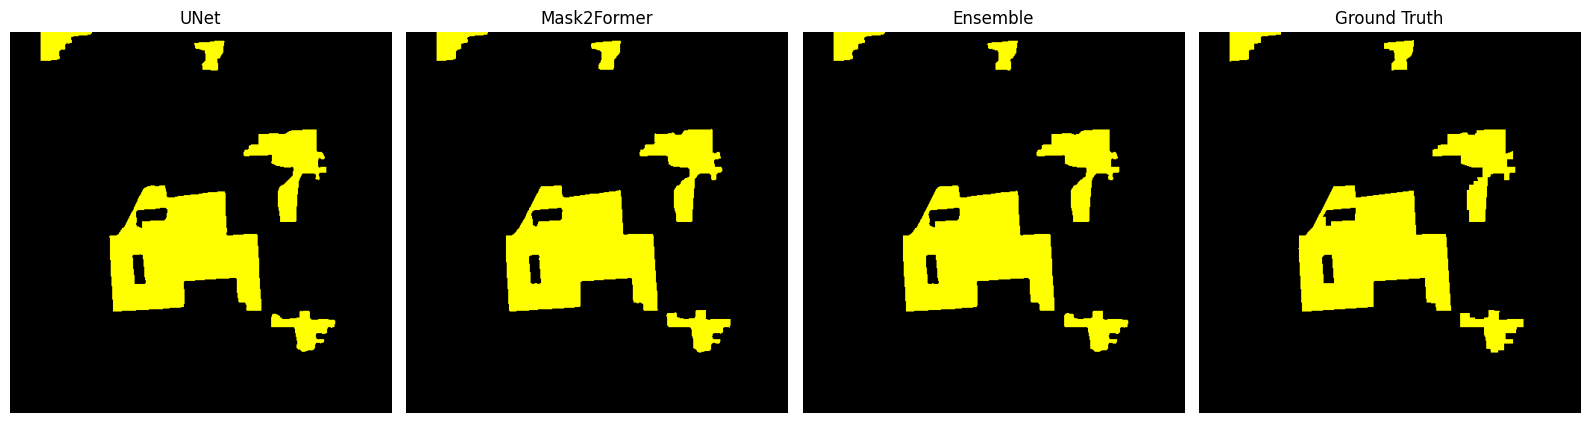

In [35]:
visualize_ensemble_pred_4panel(img, label)